In [69]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [70]:
df = pd.read_csv("datasets/monthly_in_situ_co2_mlo.csv")
df.columns = df.columns.str.strip()
df.drop([0, 1], inplace=True)
df = df.loc[:,~df.columns.duplicated()]
df.drop('Date', axis=1, inplace=True)
df['Date'] = pd.to_datetime(df[['Yr', 'Mn']].rename(columns={'Yr': 'year', 'Mn': 'month'}).assign(day=1))
df.set_index('Date', inplace=True)
df.head()

,Yr,Mn,CO2,seasonally,fit,Sta
Date,,,,,,
1958-01-01,1958,01,-99.99,-99.99,-99.99,MLO
1958-02-01,1958,02,-99.99,-99.99,-99.99,MLO
1958-03-01,1958,03,315.71,314.44,316.20,MLO
1958-04-01,1958,04,317.45,315.16,317.30,MLO
1958-05-01,1958,05,317.51,314.69,317.89,MLO


<Axes: xlabel='Date'>

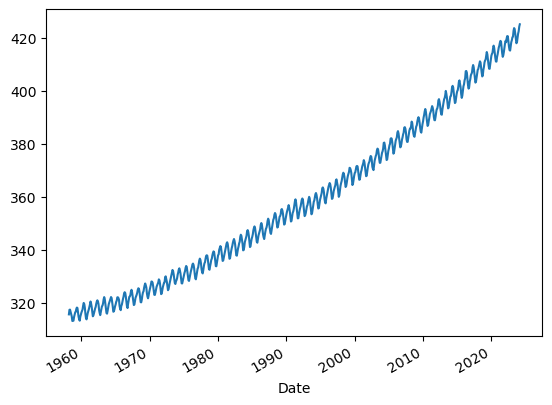

In [71]:
series = df['CO2']
series = pd.to_numeric(series, errors='coerce')
series = series.loc[series != -99.99]
series.head()
series.plot()

In [72]:
def create_lagged_features(df, lag_count):
    if isinstance(df, pd.Series):
        df = df.to_frame()
    lagged_df = df.copy()
    for i in range(1, lag_count + 1):
        lagged_df[f"lag_{i}"] = df.iloc[:, 0].shift(i)
    return lagged_df

lag_count = 3  # number of lags to use
lagged_df = create_lagged_features(series, lag_count)
lagged_df.dropna(inplace=True)
lagged_df.head()

,CO2,lag_1,lag_2,lag_3
Date,,,,
1958-07-01,315.87,317.51,317.45,315.71
1958-08-01,314.93,315.87,317.51,317.45
1958-09-01,313.21,314.93,315.87,317.51
1958-11-01,313.33,313.21,314.93,315.87
1958-12-01,314.67,313.33,313.21,314.93


In [73]:
X = lagged_df.drop('CO2', axis=1)
y = lagged_df['CO2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.2f}")

RMSE: 1.35


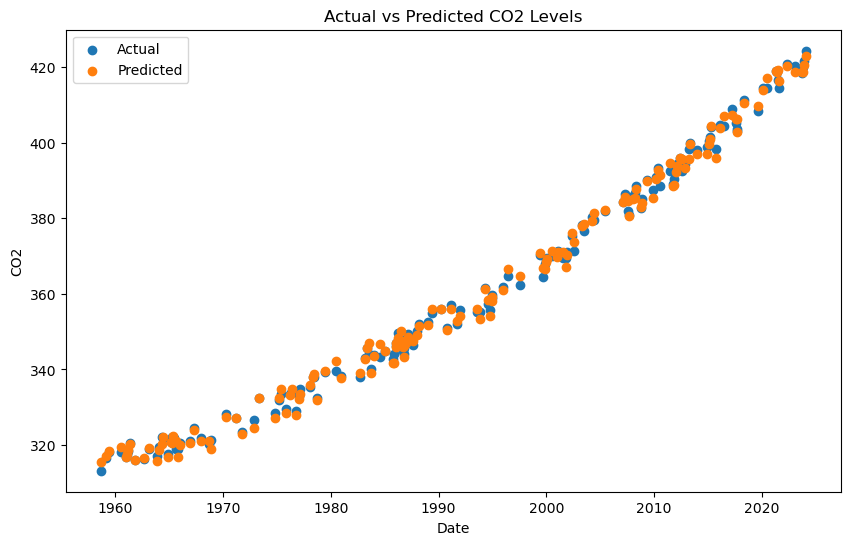

In [75]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test.index, y_test.values, label='Actual')
plt.scatter(y_test.index, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('CO2')
plt.title('Actual vs Predicted CO2 Levels')
plt.legend()
plt.show()

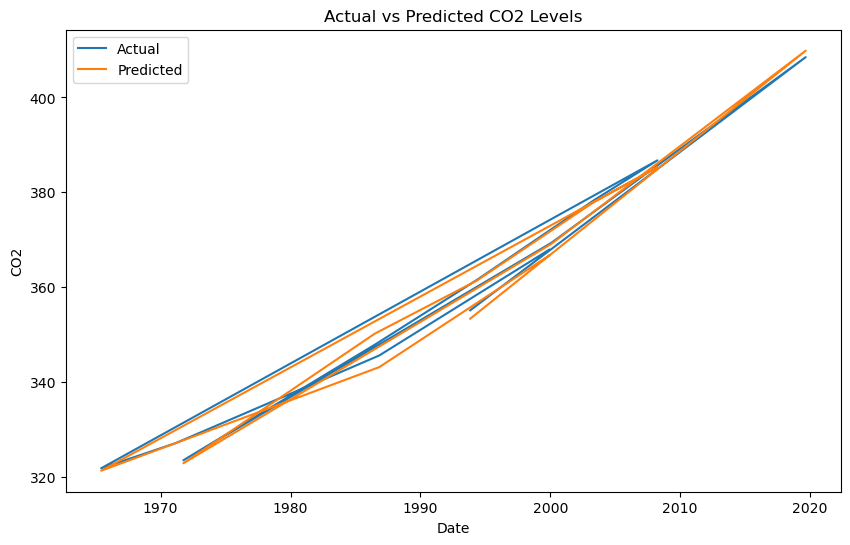

In [76]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.tail(12).index, y_test.tail(12).values, label='Actual')
plt.plot(y_test.tail(12).index, y_pred[-12:], label='Predicted')
plt.xlabel('Date')
plt.ylabel('CO2')
plt.title('Actual vs Predicted CO2 Levels')
plt.legend()
plt.show()